In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
original_dim = 784  # 28*28 for MNIST
latent_dim = 2  # Dimensionality of the latent space
intermediate_dim = 256  # Size of the hidden layer
epochs = 50
batch_size = 128


In [4]:
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)


In [5]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])


In [6]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(inputs, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(inputs, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [7]:
reconstruction_loss = binary_crossentropy(inputs, x_decoded_mean)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


In [8]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 9s 5ms/step - loss: 210.1543 - val_loss: 180.8318
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 175.9838 - val_loss: 171.6198
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 169.0324 - val_loss: 166.7636
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 165.3967 - val_loss: 164.3208
Epoch 5/50
469/469 [==============================] - 5s 10ms/step - loss: 163.2818 - val_loss: 162.7225
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 161.6002 - val_loss: 161.2917
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 160.1614 - val_loss: 159.8364
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 158.8844 - val_loss: 158.7673
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 157.6371 - val_loss: 157.6537
Epoch 10/50
469/469 [==============================] - 2s 5ms/

1/1 [==============================] - 0s 26ms/step


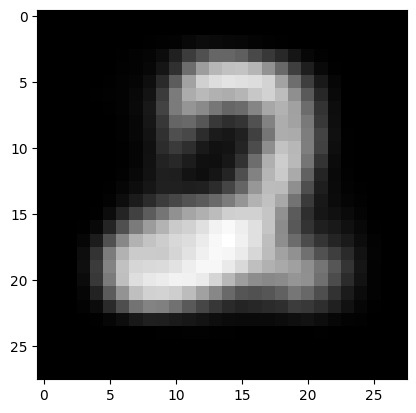

In [13]:
def plot_digit(encoded):
    decoded_img = generator.predict(np.array([encoded]))
    plt.imshow(decoded_img.reshape(28, 28), cmap='gray')
    plt.show()

# Example: Generate a random digit
random_encoded = np.random.normal(size=(latent_dim,))
plot_digit(random_encoded)
